# Pulsed-Laser Polymerization 🔦

## Introduction

Pulsed-laser polymerization coupled with size-exclusion chromatography (PLP-SEC) is the recommended method for experimentally determining the propagation rate coefficients ($k_p$) in radical polymerization. This method, originally developed by Olaj and co-workers in the late 1980s, involves periodically irradiating a monomer solution sample containing a small amount of photoinitiator with laser pulses. When the experimental conditions are suitable, the molar mass distribution of the resulting polymer exhibits a characteristic pattern from which the $k_p$ value can be inferred.

The governing equations for this system largely mirror those of a standard transient process (refer to this [notebook](./radical_batch_polymerization.ipynb)). The key difference lies in the (photo)initiation step. Following the works of [Hutchinson et al. (1994)] and [Nikitin et al. (2003)], the reaction scheme can be written as follows:

\begin{align*}
I                         & \xrightarrow{h\nu}     2 I^{\cdot} \\

I^{\cdot} + M             & \xrightarrow{k_i}      R_1^{\cdot} \\

R_n^{\cdot} + M           & \xrightarrow{k_p}      R_{n+1}^{\cdot} \\

R_n^{\cdot} + M           & \xrightarrow{k_{tr,M}} P_{n} + R_1^{\cdot} \\

R_n^{\cdot} + R_m^{\cdot} & \xrightarrow{k_{tc}}   P_{n+m} \\

R_n^{\cdot} + R_m^{\cdot} & \xrightarrow{k_{td}}   P_n + P_m \\

R_n^{\cdot} + I^{\cdot}   & \xrightarrow{k_{t}}    P_n \\

I^{\cdot} + I^{\cdot}     & \xrightarrow{k_{t}}    dead \\
\end{align*}

Assuming constant volume and constant rate coefficients (i.e., no chain-length dependence), the transient species balances can be expressed as:

\begin{align}
\frac{\textrm{d}[I^{\cdot}]}{\textrm{d}t}   & = [\Delta I^{\cdot}]\sum_{j} \delta(t-j t_p) - \left( k_i[M] + k_t [T^{\cdot}] \right)[I^{\cdot}] \\
\frac{\textrm{d}[M]}{\textrm{d}t}           & = - \left( k_i [I^{\cdot}] + (k_p + k_{tr,M})[R^{\cdot}] \right)[M] \\
\frac{\textrm{d}[R_1^{\cdot}]}{\textrm{d}t} & = k_i[M][I^{\cdot}] + k_{tr,M}[M][R^{\cdot}] - \left((k_p + k_{tr,M})[M] + k_t [T^{\cdot}]\right)[R_1^{\cdot}]  \\
\frac{\textrm{d}[R_n^{\cdot}]}{\textrm{d}t} & = k_p[M][R_{n-1}^{\cdot}] - \left((k_p + k_{tr,M})[M] + k_t [T^{\cdot}]\right)[R_n^{\cdot}], \; n \ge 2 \\
\frac{\textrm{d}[P_n]}{\textrm{d}t} & = \left(  k_{tr,M} [M] + k_{td} [R^{\cdot}] + k_t[I^{\cdot}]\right)[R_n^{\cdot}]
+ \tfrac{1}{2} k_{tc} \sum_{j=1}^{n-1}[R_{n-j}^{\cdot}][R_j^{\cdot}] \\
\frac{\textrm{d}[R^{\cdot}]}{\textrm{d}t}   & =  k_i[M][I^{\cdot}]  - k_t [T^{\cdot}][R^{\cdot}] \\
\frac{\textrm{d}[P]}{\textrm{d}t}           & =  \left( k_{tr,M} [M] + k_{td} [R^{\cdot}] + k_t[I^{\cdot}] \right)[R^{\cdot}] + \tfrac{1}{2} k_{tc} [R^{\cdot}]^2
\end{align}

```{note}
These equations do _not_ follow IUPAC's $2k_t$ convention. I intentionally did not convert them to emphasize that both conventions are widely used, and one needs to be aware of this.
``` 

Here, $[\Delta I^{\cdot}]$ represents the burst of primary radicals generated immediately following each laser pulse, and $t_p$ refers to the time interval between successive laser pulses. The last two equations describe the evolution of the zeroth moments of $R^{\cdot}$ (the total radical concentration) and $P$ (the total dead polymer concentration), where $[R^{\cdot}] = \sum_n [R_n^{\cdot}]$ and $[P] = \sum_n [P_n]$. Moreover, we've defined $[T^{\cdot}] := [R^{\cdot}] + [I^{\cdot}]$.

By setting an appropriate upper limit for the chain length, $N$, we obtain a closed system of $2N + 4$ ordinary differential equations (ODEs). While, as discussed in this [notebook](./radical_batch_polymerization.ipynb), directly integrating such an ODE system may not be the most computationally efficient approach, it is straightforward to implement.

[Hutchinson et al. (1994)]: https://doi.org/10.1021/ma00094a016
[Nikitin et al. (2003)]: https://doi.org/10.1002/mats.200350005

## Numerical Solution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, prange
from scipy.integrate import solve_ivp

### Model Equations

As in previous examples, we begin by defining a function `model_xdot` to compute the time derivative of the state vector. To enhance performance, this function is jitted using [Numba](https://numba.pydata.org/). Moreover, we write a separate auxiliary function `convolve` to carry out the convolution of the radical distributions, as required to evaluate the termination by combination term — the corresponding NumPy function performs rather poorly inside a Numba-jitted function.

In [2]:
@jit(fastmath=True, parallel=True)
def convolve(P: np.ndarray) -> np.ndarray:
    """Convolve a distribution with itself."""
    Q = np.zeros_like(P)
    for n in prange(2, P.size):
        accum = 0.0
        for i in range(1, n):
            accum += P[i]*P[n-i]
        Q[n] = accum
    return Q  

In [3]:
@jit(fastmath=True)
def model_xdot(t: float,
               x: np.ndarray,
               ki: float,
               kp: float,
               ktc: float,
               ktd: float,
               kfm: float,
               N: int
               ) -> np.ndarray:
    """Calculate the derivative of the state vector, dx/dt.

    x = [I, M, r0, p0, R_0..R_N, P_0..P_N]

    r0 = Σ(Rn)
    p0 = Σ(Pn)
    
    Parameters
    ----------
    t : float
        Time.
    x : np.ndarray
        State vector.
    ki : float
        Initiation rate coeficient.
    kp : float
        Propagation rate coeficient.
    ktc : float
        Termination by combination rate coeficient.
    ktd : float
        Termination by disproportionation rate coeficient.
    kfm : float
        Transfer to monomer rate coeficient.
    N : int
        Maximum chain length.

    Returns
    -------
    np.ndarray
        Time derivative of the state vector.
    """
    # Unpack the state vector
    I = x[0]
    M = x[1]
    r0 = x[2]
    # p0 = y[3]
    R = x[4:N+5]
    # P = y[N+5:]

    # Total radical concentration
    T = I + r0
    
    # Total termination rate
    kt = ktc + ktd

    # Allocate derivative vector and component views
    xdot = np.empty_like(x)
    Idot = xdot[0:1]
    Mdot = xdot[1:2]
    r0dot = xdot[2:3]
    p0dot = xdot[3:4]
    Rdot = xdot[4:N+5]
    Pdot = xdot[N+5:]

    # Derivatives
    Idot[:] = -(ki*M + kt*T)*I
    Mdot[:] = -(ki*I + (kp + kfm)*r0)*M
    r0dot[:] = ki*I*M - kt*T*r0
    p0dot[:] = (kfm*M + ktd*r0 + kt*I)*r0 + 0.5*ktc*r0**2
    Rdot[:] = -((kp + kfm)*M + kt*T)*R
    Rdot[1] += (ki*I + kfm*r0)*M
    Rdot[2:] += kp*M*R[1:-1]
    if ktc > 1e0:
        Pdot[:] = 0.5*ktc*convolve(R)
    else:
        Pdot[:] = 0.
    Pdot += (kfm*M + ktd*r0 + kt*I)*R

    return xdot

Then, we perform the numerical integration using a suitable ODE solver. This system is _very_ [stiff](https://en.wikipedia.org/wiki/Stiff_equation), therefore we need to choose an implicit solver like `LSODA`. The laser pulses cause a discontinuity in $[I^{\cdot}]$, so each period must be integrated independently, and the concentration of $I^{\cdot}$ updated for the next pulse.

In [4]:
def solve_model(M0: float,
                dI: float,
                kp: float,
                kt: float,
                alpha: float,
                CtrM: float,
                prr: float,
                npulses: int,
                N: int | None = None,
                ) -> tuple[np.ndarray, ...]:
    """Solve the dynamic model.

    Parameters
    ----------
    M0 : float
        Initial monomer concentration.
    dI : float
        Primary radical burst.
    kp : float
        Propagation rate coefficient.
    kt : float
        Termination rate coefficient.
    alpha : float
        Relative contribution of disportionation, ktd/kt.
    CtrM : float
        Ratio of transfer to monomer, ktrM/kp.
    prr : float
        Pulse repetition rate.
    npulses : int
        Number of pulses.
    N : int
        Maximum chain length.

    Returns
    -------
    tuple[np.ndarray, ...]
        idx_pulses, t, s, I, M, r0, p0, R, P
    """

    # PLP period
    tp = 1/prr

    # Estimate required maximum chain length
    if N is None:
        N = 10*round(kp*M0*tp)

    # Chain lengths (include length 0, to make indexing easier)  
    s = np.arange(0, N+1)

    # Initial conditions
    R0 = np.zeros_like(s)
    P0 = np.zeros_like(s)
    x0 = np.concatenate(([0.+dI, M0, R0.sum(), P0.sum()], R0, P0))

    # Rate coefficients
    ki = kp 
    kfm = kp*CtrM
    ktd = kt*alpha
    ktc = kt*(1 - alpha)

    # Absolute tolerances (very important!)
    atol = np.concatenate(([1e-13, 1e0, 1e-9, 1e-6], 
                           1e-13*np.ones_like(R0),
                           1e-10*np.ones_like(P0)))

    # Solve ODE set for each pulse
    t0 = 0.
    solutions = []
    idx_pulses = []
    for _ in range(npulses):
        solution = solve_ivp(model_xdot,
                             t_span=(t0, t0+tp),
                             y0=x0,
                             args=(ki, kp, ktc, ktd, kfm, N),
                             method='LSODA',  # implicit solver is a MUST
                             rtol=1e-4,
                             atol=atol)

        solutions.append(solution)
        idx_pulses.append(solution.t.size)

        # Update initial conditions for the next pulse
        t0 = solution.t[-1]
        x0 = solution.y[:, -1].copy()
        x0[x0 < 1e-15] = 0.  # discard numerical noise
        x0[0] += dI          # add primary radical burst

    # Unpack the solution
    idx_pulses = np.cumsum(idx_pulses) - 1
    t = np.concatenate([solution.t for solution in solutions])
    x = np.hstack([solution.y for solution in solutions])
    I = x[0, :]
    M = x[1, :]
    r0 = x[2, :]
    p0 = x[3, :]
    R = x[4:N+5, :]
    P = x[N+5:, :]

    return idx_pulses, t, s, I, M, r0, p0, R, P

### Input Parameters

We will use the parameters for bulk methyl methacrylate (MMA) at 40°C, as reported by [Hutchinson et al. (1994)].

In [5]:
# Monomer concentration (bulk)
MM = 100.121 # g/mol
rho = 940.   # g/L
M0 = rho/MM  # mol/L

# Rate coefficients
kp = 480     # L/(mol.s)
kt = 5e7     # L/(mol.s)
alpha = 1.0  # alpha=1 corresponds to 100% disportionation
CtrM = 8e-6

# Laser and photoinitator parameters
prr = 10     # Hz
dI = 0.5e-6  # mol/L

# Numerical settings
npulses = 5

### ODE Solution

Finally, we perform the integration. The duration of this operation depends on the size of $N$, the time scale of the fastest reaction (which is typically the propagation step), and especially on whether termination by combination is considered.

In [6]:
idx_pulses, t, s, I, M, r0, p0, R, P = \
    solve_model(M0, dI, kp, kt, alpha, CtrM, prr, npulses, N=4000)

On my computer, the solution takes about 1 second without termination by combination and $10^1$ seconds otherwise. The original paper from [Hutchinson et al. (1994)], reports 1500 seconds of compute time without termination by combination, so it seems we've gained 3 orders of magnitude in 3 decades. Not too bad! 😉

### Plots

#### Reactant and Polymer (0-th moment) Concentrations

Text(0.5, 58.7222222222222, 'Time (s)')

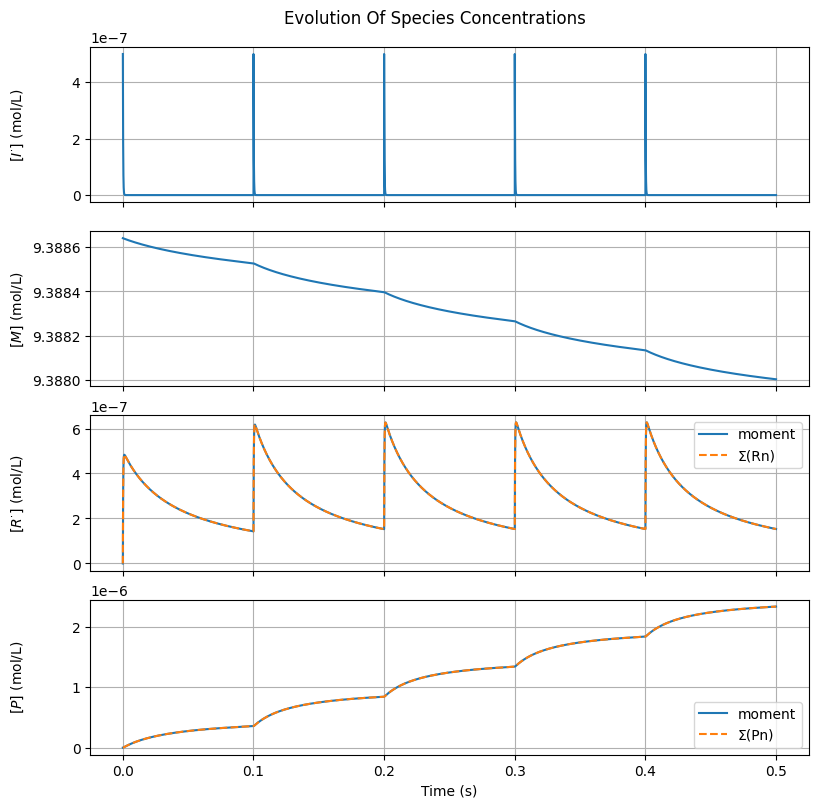

In [7]:
fig1, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 8))

fig1.suptitle("Evolution of species concentrations".title())
fig1.tight_layout()
fig1.align_ylabels()

# Add trace for [I*]
ax[0].plot(t, I)
ax[0].set_ylabel(r"$[I^{\cdot}]$" + " (mol/L)")
ax[0].grid(True)

# Add trace for [M]
ax[1].plot(t, M)
ax[1].set_ylabel(r"$[M]$" + " (mol/L)")
ax[1].grid(True)

# Add trace for [R*]
ax[2].plot(t, r0, label='moment')
ax[2].plot(t, R.sum(axis=0), linestyle='--', label='Σ(Rn)')
ax[2].set_ylabel(r"$[R^{\cdot}]$" + " (mol/L)")
ax[2].grid(True)
ax[2].legend()

# Add trace for [P]
ax[3].plot(t, p0, label='moment')
ax[3].plot(t, P.sum(axis=0), linestyle='--', label='Σ(Pn)')
ax[3].set_ylabel(r"$[P]$" + " (mol/L)")
ax[3].grid(True)
ax[3].legend(loc='lower right')

ax[-1].set_xlabel("Time (s)")


The values of $[R^{\cdot}]$ and $[P]$ computed by the moment method and by summing the full distribution are in excellent agreement, suggesting the equations are correctly implemented and $N$ is high enough.

#### Chain Length Distribution

Text(0.5, 58.7222222222222, 'Molar mass [g/mol]')

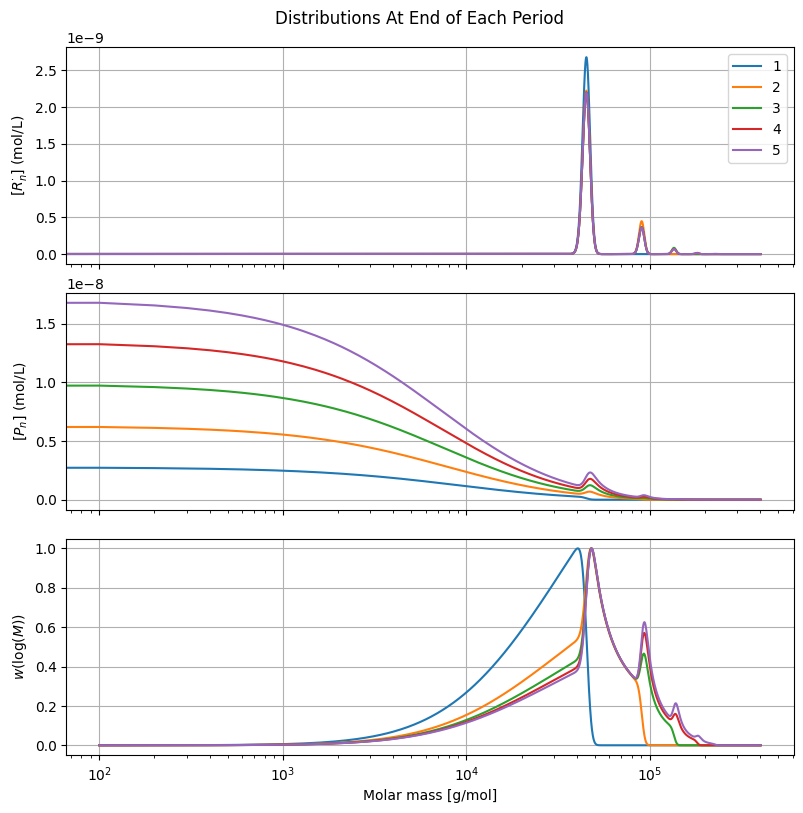

In [8]:
fig2, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
fig2.suptitle("Distributions At End of Each Period")
fig2.tight_layout()
fig2.align_ylabels()

# Number distribution
CLDn = P/(p0[np.newaxis, :] + 1e-50)

# GPC distribution normalized by peak
CLDgpc = (s[:, np.newaxis]**2)*CLDn
CLDgpc /= (CLDgpc.max(axis=0)[np.newaxis, :] + 1e-50)

for pulse, idx in enumerate(idx_pulses):
    label = f"{pulse+1}"
    ax[0].plot(MM*s, R[:, idx], label=label)
    ax[1].plot(MM*s, P[:, idx])
    ax[2].plot(MM*s[1:], CLDgpc[1:, idx])

ax[0].legend()
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].set_ylabel(r"$[R_n^{\cdot}]$" + " (mol/L)")
ax[1].set_ylabel(r"$[P_n]$" + " (mol/L)")
ax[2].set_ylabel(r"$w(\log(M))$")
ax[-1].set_xscale('log')
ax[-1].set_xlabel("Molar mass [g/mol]")


Note how the dominant features of the molar mass distribution become visible after just a few pulses. 

## Animation

The plots above show the distributions at the end of each period (i.e., just before the next laser pulse). While these are informative, an animation will make the process much easier to understand.

In [9]:
from matplotlib.animation import PillowWriter

Uncomment and run the code below if you want to generate the animation.

```{note}
The animation has a relatively high time resolution and, thus, may take several minutes to complete.
```

In [10]:
# fig3, ax = plt.subplots(3, 1, figsize=(8, 10))
# fig3.suptitle("PLP-SEC Simulation")
# fig3.tight_layout()
# fig3.subplots_adjust(left=0.08, bottom=0.05)

# # Total radical concentration, [R*]
# line_R, = ax[0].plot([], [])
# ax[0].set_ylabel(r"$[R^{\cdot}]$" + " (mol/L)")
# ax[0].set_xlabel("Time (s)")
# ax[0].set_xlim(t[(0, -1),])
# ax[0].set_ylim(0., r0.max())

# # Concentration of each radical, [Rn*]
# line_Rn, = ax[1].plot([], [])
# ax[1].set_ylabel(r"$[R_n^{\cdot}]$" + " (a.u.)")
# ax[1].set_xlim(s[(0, -1),])
# ax[1].set_xscale('log')
# ax[1].set_ylim(0., 1.)

# # GPC distribution of dead polymer P
# line_GPC, = ax[2].plot([], [])
# ax[2].set_ylabel(r"$w(\log(n))$" + " (a.u.)")
# ax[2].set_xlabel("Chain length")
# ax[2].set_xlim(s[(0, -1),])
# ax[2].set_xscale('log')
# ax[2].set_ylim(0., 1.)

# # Animation
# fps = 40
# step = 10
# writer = PillowWriter(fps=fps)
# with writer.saving(fig3, "animation_PLP-SEC.gif", 150):
#     for i in range(0, t.size, step):
#         line_R.set_data(t[0:i], r0[0:i])
#         line_Rn.set_data(s, R[:, i]/(R[:, i].max() + 1e-50))
#         line_GPC.set_data(s, CLDgpc[:, i])
#         writer.grab_frame()
#         if i + step > t.size - 1:
#             for ii in range(2*fps):
#                 writer.grab_frame()

## 🔎 Questions

1. What additional calculation can be made to verify if $[P_n]$ is consistent?
1. How do $k_t$ and $[\Delta I^{\cdot}]$ affect the structure of the chain length distribution?
1. How does $prr$ influence the structure of the chain length distribution?
    * Hint: Be cautious when decreasing $prr$, as you may encounter numerical issues.
1. What is the (theoretical) key to achieving a good PLP structure?
1. What happens if backbiting (intramolecular chain transfer) is significant under the measurement conditions?
1. Can you extend the model to include backbiting?